In [1]:

import pandas as pd
import numpy as np
import re
import math
import os
import subprocess

# Text and feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc)

# Classifier
from sklearn.naive_bayes import GaussianNB

# Text cleaning & stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/dwika/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from br_classification import remove_html,remove_emoji,remove_stopwords,clean_str


[nltk_data] Downloading package stopwords to /Users/dwika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== Naive Bayes + TF-IDF Results ===
Number of repeats:     10
Average Accuracy:      0.6238
Average Precision:     0.6056
Average Recall:        0.7402
Average F1 score:      0.5519
Average AUC:           0.7402

Results have been saved to: ../pytorch_NB.csv


In [3]:
NLTK_stop_words_list = stopwords.words('english')
custom_stop_words_list = ['...']  # You can customize this list as needed
final_stop_words_list = NLTK_stop_words_list + custom_stop_words_list


In [4]:
project = 'pytorch'
path = f'datasets/{project}.csv'

pd_all = pd.read_csv(path)
pd_all = pd_all.sample(frac=1, random_state=999)  # Shuffle

# Merge Title and Body into a single column; if Body is NaN, use Title only
pd_all['Title+Body'] = pd_all.apply(
    lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'],
    axis=1
)

# Keep only necessary columns: id, Number, sentiment, text (merged Title+Body)
pd_tplusb = pd_all.rename(columns={
    "Unnamed: 0": "id",
    "class": "sentiment",
    "Title+Body": "text"
})
pd_tplusb.to_csv('Title+Body.csv', index=False, columns=["id", "Number", "sentiment", "text"])


In [5]:
project = 'pytorch'
path = f'datasets/{project}.csv'

pd_all = pd.read_csv(path)
pd_all = pd_all.sample(frac=1, random_state=999)  # Shuffle


In [6]:
########## 4. Configure parameters & Start training ##########

# ========== Key Configurations ==========

# 1) Data file to read
datafile = 'Title+Body.csv'

# 2) Number of repeated experiments
REPEAT = 10

# 3) Output CSV file name
out_csv_name = f'../{project}_NB.csv'

# ========== Read and clean data ==========
data = pd.read_csv(datafile).fillna('')
text_col = 'text'

# Keep a copy for referencing original data if needed
original_data = data.copy()

# Text cleaning
data[text_col] = data[text_col].apply(remove_html)
data[text_col] = data[text_col].apply(remove_emoji)
data[text_col] = data[text_col].apply(remove_stopwords)
data[text_col] = data[text_col].apply(clean_str)

# ========== Hyperparameter grid ==========
# We use logspace for var_smoothing: [1e-12, 1e-11, ..., 1]
params = {
    'var_smoothing': np.logspace(-12, 0, 13)
}

# Lists to store metrics across repeated runs
accuracies  = []
precisions  = []
recalls     = []
f1_scores   = []
auc_values  = []

In [7]:
data

,id,Number,sentiment,text
0,688,17355,0,the python doc global op carried source. bug m...
1,616,13787,0,dataloader segmentation fault using mpi backen...
2,322,18998,0,torch.from pil( ) request ? . feature a simple...
3,241,4302,0,torch.halftensor object attribute mean. result...
4,647,367,0,support dilation conv1d conv3d
...,...,...,...,...
747,225,14864,0,discussion recommend different file extension ...
748,712,24991,0,feature request add support selu activation ca...
749,481,14653,0,jit error reporting imported modules highlight...
750,348,19969,0,libtorch segmentation fault rhel 7 easy reprod...


In [18]:
indices = np.arange(data.shape[0])
train_index, test_index = train_test_split(
        indices, test_size=0.2, random_state=0
    )
train_index

array([495, 251,  97, 520, 473, 401, 618, 181, 586, 261,  17, 666, 252,
       333, 334, 293, 691, 386, 678, 465,  45, 312,  62, 712, 327, 267,
       140, 302, 533, 127, 424, 364, 625, 144, 355,  21, 597, 392,  35,
       456, 240, 299,  77, 746, 241, 272, 109, 242, 417, 101, 306, 258,
       230, 576, 285, 735, 395, 356, 741, 698, 211, 253, 165, 188, 578,
       268,  34, 545, 316, 748, 249, 460, 624, 155, 271, 427, 468, 517,
       200, 247, 729, 319,  12, 161, 413, 453, 493, 692, 518, 159, 529,
       428, 229,  78,  92, 523,  66, 303, 352, 609, 310, 687, 369, 409,
       580, 667,  15, 245, 283,   6, 313, 331, 104, 436, 390, 416,  90,
       725, 389, 452, 218, 570, 530, 205, 738, 190, 477, 367, 194, 467,
       132, 233, 173, 178, 727, 569, 206, 536,  96, 645, 587, 425,  89,
       553, 179,   0,  46, 171, 742, 362, 107, 133, 496, 223, 582, 102,
       108, 213, 740, 315, 246, 602, 407, 125, 437, 583, 399, 608, 224,
        26, 623, 527, 492,   3, 134, 325, 350, 186, 564, 295, 74

In [19]:
test_index

array([647, 142, 415,  79, 214,  40, 397,  27, 263, 318, 673, 317, 422,
        14, 572, 531,  31, 534, 651, 479, 162, 406, 344, 463, 418, 391,
       449, 193, 346, 156, 202, 538, 722, 278, 103, 516,   8, 243, 505,
       122, 747, 613, 568,  75, 204, 404, 157, 222,   1, 294, 434,  55,
       650, 382, 693, 665, 363, 365, 585, 235, 542, 113, 170, 490, 636,
       210, 674, 612, 556, 605, 337, 521, 614, 454, 567, 546, 573, 375,
       250,  85, 236, 487, 187,  18, 172, 688, 595, 702,  50, 744, 519,
       714, 408, 592, 385, 374,  10,  68, 279, 255,   2, 745, 451, 743,
       654, 435, 644, 588, 696, 231, 351, 239, 400, 681, 175, 215, 366,
       360, 591, 526,  71,  49, 266, 402, 354, 649, 502, 474,  37, 694,
        48, 685, 628, 196, 503,  76,  64, 603,  52, 301, 403, 506, 338,
       641, 620, 462, 466, 118, 447, 575, 751])

In [20]:
train_text = data[text_col].iloc[train_index]
train_text

495    getting build error. i building pytorch i gett...
251    document torch.quantize per tensor torch.quant...
97     bug fail throw error computing loss tensors sh...
520    feature request pytorch more flexible optimize...
473    nccl hang pytorch distributed data parallel mi...
                             ...                        
707    mysterious tensor indexing problem. bug indexi...
192    migrate ` multinomial alias setup` th aten (cp...
629    build nccl failed build libnccl debian unstabl...
559    switch cuda svd qr using cusolver. currently u...
684    detach working properly stochastic variables. ...
Name: text, Length: 601, dtype: object

In [21]:
y_train = data['sentiment'].iloc[train_index]
y_test  = data['sentiment'].iloc[test_index]

In [22]:
test_text = data[text_col].iloc[test_index]

In [ ]:
tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=1000  # Adjust as needed
    )
X_train = tfidf.fit_transform(train_text) # this one traisn
X_test = tfidf.transform(test_text) 

In [33]:
feature_names = tfidf.get_feature_names_out()
X_test_df = pd.DataFrame(X_test.toarray(), columns=feature_names)

In [34]:
X_train.shape

(601, 1000)

In [35]:
from sklearn.decomposition import PCA

In [58]:
#Visualizing data with PCA 

pca=PCA(n_components=5)
x_pca=pca.fit_transform(X_test_df)
component_names =[f"PCA{i+1}" for i in range (x_pca.shape[1])]
x_pca=pd.DataFrame(x_pca, columns= component_names)
x_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5
0,0.217689,0.021846,0.155751,0.164019,0.001691
1,-0.066134,-0.121501,-0.088451,0.084968,-0.041184
2,0.174211,-0.099548,0.071902,0.178069,0.023275
3,0.053240,-0.164664,0.063138,-0.103023,-0.167831
4,0.439933,-0.128426,-0.329483,-0.118040,0.043788


In [59]:
x_pca.shape

(151, 5)

In [60]:
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=component_names,  
    index=feature_names  
)
loadings

,PCA1,PCA2,PCA3,PCA4,PCA5
00,0.000315,-0.000950,-0.001100,-0.001613,-0.000487
04,0.096496,-0.020332,-0.015040,0.005933,-0.023289
04 cmake,0.019176,-0.003972,-0.022597,-0.004806,-0.002254
04 lts,0.041698,-0.009220,-0.026910,-0.007734,-0.007575
08,0.002185,-0.000780,0.007014,-0.000772,-0.009031
...,...,...,...,...,...
yes cuda,0.041960,-0.017026,-0.046290,-0.020400,-0.009003
you,0.020606,0.010877,0.055342,0.000209,0.001585
you get,0.033209,0.017425,0.059482,0.011505,0.026638
zero,-0.009534,0.016564,-0.003755,0.042381,0.027020


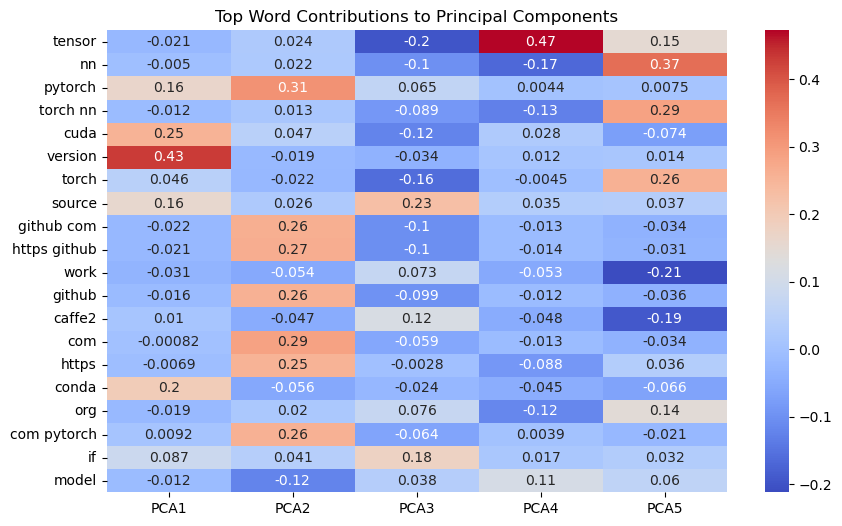

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns


top_words = loadings.abs().sum(axis=1).sort_values(ascending=False).head(20).index
plt.figure(figsize=(10, 6))
sns.heatmap(loadings.loc[top_words], annot=True, cmap="coolwarm")
plt.title("Top Word Contributions to Principal Components")
plt.show()

In [62]:
import itertools

10
12


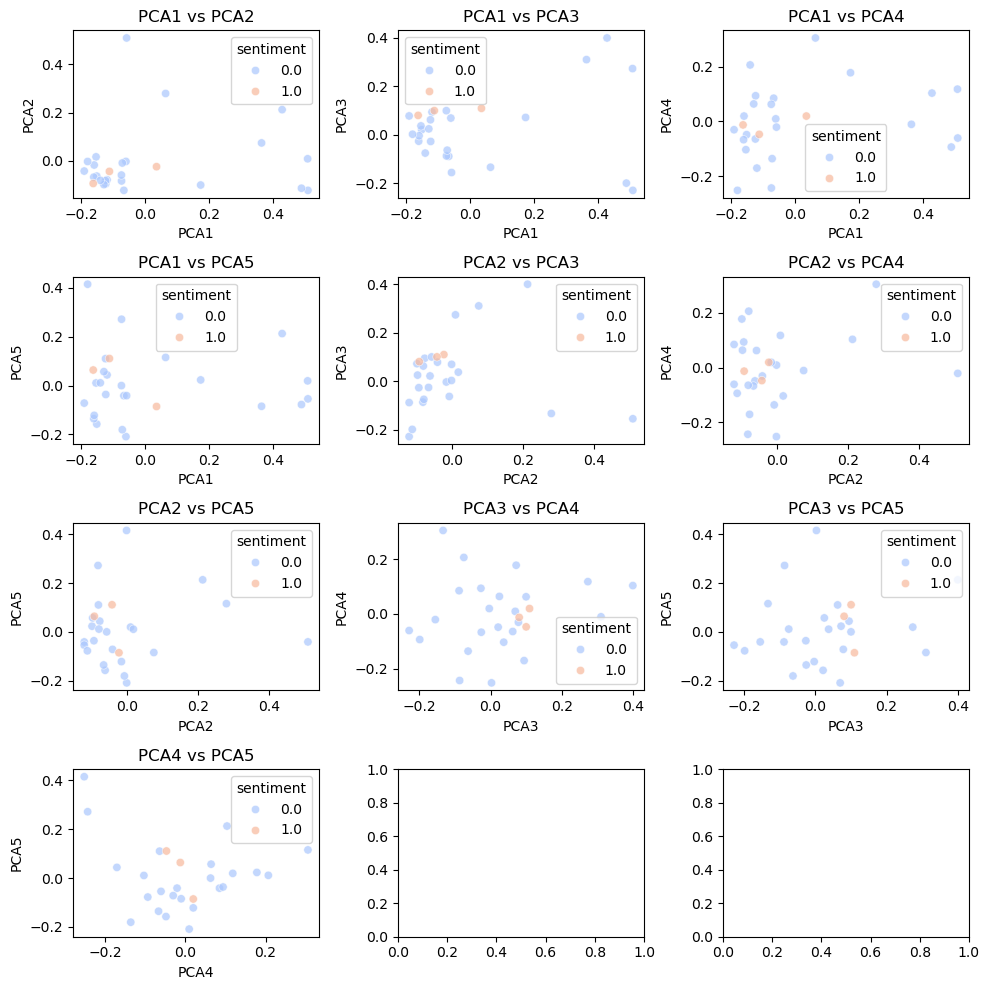

In [65]:
# Visualizing PCA pairs
target = y_test  # Assuming y_train contains class labels

# Try all unique pairs of principal components
pc_pairs = list(itertools.combinations(component_names, 2))
print(len(pc_pairs))

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))  # Adjust based on number of PCs
axes = axes.flatten()
print(len(axes))
for i, (pc1, pc2) in enumerate(pc_pairs):
    if i >= len(axes):  # Avoid plotting more than available subplots
        break
    sns.scatterplot(x=x_pca[pc1], y=x_pca[pc2], hue=target, ax=axes[i], palette="coolwarm", alpha=0.7)
    axes[i].set_title(f"{pc1} vs {pc2}")
plt.tight_layout()
plt.show()




In [66]:
explained_variance_ratio=pca.explained_variance_ratio_
explained_variance_ratio

array([0.04311941, 0.02730008, 0.02378779, 0.02066314, 0.01892892])

In [67]:
covarianceDF= pd.DataFrame(explained_variance_ratio*100).T
covarianceDF.columns=component_names
covarianceDF

,PCA1,PCA2,PCA3,PCA4,PCA5
0,4.311941,2.730008,2.378779,2.066314,1.892892


### Result :
Result shows PCA capturing little covariance this means that as expected TF IDF generates multiple columns and rows , this means the data shows high multidimensionality
 Of course its obvious with the shape of the TF-IDF taking over 600 columns but proving this with PCA gives us a better reasoning
 this means that linear models like Linear Regressions, or SVM would not be performing well, unless somehow we are able to reduce the into smaller weights dimensionality

Can we do a sentiment based anlysis of such data ? # Probably not becuase sentiment based analysis 
    predicts three classification good , neutral , and bad , also I probably dont need to show the whole plot comparison thing
    just show the PCA , and maybe switch it up to other than TF IDF and compare the performance of PCA, but this justifies that mmodels like SVM or Linear Regression would not be the perfect fit
    as those 2 models can only seperate data that 2 or 3 dimensionality even in nonlinear models both SVM and Linear Regression can only work if those data are seperable in on a differnet hyperplane 
    if the hyperplane is more than 3 we cant visualize it nor can SVM which relies heavily on sperating data on a linear space 

Traditional models like Support Vector Machines (SVM) and Linear Regression may not be the most suitable choices for high-dimensional and complex datasets, particularly when the decision boundary is not well-defined in a lower-dimensional space. While SVM can handle nonlinearly separable data by utilizing the kernel trick to project the data into a higher-dimensional feature space, it still fundamentally relies on the existence of a separating hyperplane. If the data cannot be effectively separated even in this transformed space, the model's performance may degrade.

Linear regression, by design, assumes a linear relationship between the input features and the target variable. It is inherently unsuitable for complex, high-dimensional data where interactions between variables are nonlinear and cannot be effectively captured through simple linear transformations.

Furthermore, while SVM can separate data in higher-dimensional spaces, its effectiveness diminishes when the dimensionality increases significantly. As the feature space expands (e.g., beyond three or four dimensions), challenges such as the curse of dimensionality arise. In very high-dimensional spaces, data points tend to become more sparsely distributed, and the model may struggle to identify a meaningful hyperplane for separation. Although theoretically, SVM can operate in any dimensional space, in practice, it depends on the data being separable in some projected space, which is not always guaranteed.
probably lets not make this section too long cause it shouldnt be more than 6 pages

In [70]:
import matplotlib.pyplot as plt

In [82]:
for repeated_time in range(REPEAT):
    # --- 4.1 Split into train/test ---
    indices = np.arange(data.shape[0])
    train_index, test_index = train_test_split(
        indices, test_size=0.2, random_state=repeated_time
    )

    train_text = data[text_col].iloc[train_index]
    test_text = data[text_col].iloc[test_index]

    y_train = data['sentiment'].iloc[train_index]
    y_test  = data['sentiment'].iloc[test_index]

    # --- 4.2 TF-IDF vectorization ---
    tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=1000  # Adjust as needed
    )
    X_train = tfidf.fit_transform(train_text)
    X_test = tfidf.transform(test_text)
   
    # --- 4.3 Naive Bayes model & GridSearch ---
    clf = GaussianNB()
    grid = GridSearchCV(
        clf,
        params,
        cv=5,              # 5-fold CV (can be changed)
        scoring='roc_auc'  # Using roc_auc as the metric for selection
    )
    grid.fit(X_train.toarray(), y_train)

    # Retrieve the best model
    best_clf = grid.best_estimator_
    best_clf.fit(X_train.toarray(), y_train)

    # --- 4.4 Make predictions & evaluate ---
    y_pred = best_clf.predict(X_test.toarray())

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Precision (macro)
    prec = precision_score(y_test, y_pred, average='macro')
    precisions.append(prec)

    # Recall (macro)
    rec = recall_score(y_test, y_pred, average='macro')
    recalls.append(rec)

    # F1 Score (macro)
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores.append(f1)

    # AUC
    # If labels are 0/1 only, this works directly.
    # If labels are something else, adjust pos_label accordingly.
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_val = auc(fpr, tpr)
    auc_values.append(auc_val)

# --- 4.5 Aggregate results ---
final_accuracy  = np.mean(accuracies)
final_precision = np.mean(precisions)
final_recall    = np.mean(recalls)
final_f1        = np.mean(f1_scores)
final_auc       = np.mean(auc_values)

print("=== Naive Bayes + TF-IDF Results ===")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy:.4f}")
print(f"Average Precision:     {final_precision:.4f}")
print(f"Average Recall:        {final_recall:.4f}")
print(f"Average F1 score:      {final_f1:.4f}")
print(f"Average AUC:           {final_auc:.4f}")

# Save final results to CSV (append mode)
try:
    # Attempt to check if the file already has a header
    existing_data = pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log = pd.DataFrame(
    {
        'repeated_times': [REPEAT],
        'Accuracy': [final_accuracy],
        'Precision': [final_precision],
        'Recall': [final_recall],
        'F1': [final_f1],
        'AUC': [final_auc],
        'CV_list(AUC)': [str(auc_values)]
    }
)

df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)

print(f"\nResults have been saved to: {out_csv_name}")

=== Naive Bayes + TF-IDF Results ===
Number of repeats:     10
Average Accuracy:      0.8115
Average Precision:     0.6496
Average Recall:        0.5741
Average F1 score:      0.5132
Average AUC:           0.5741

Results have been saved to: ../pytorch_NB.csv


In [ ]:
#Random Classifier

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [86]:
for repeated_time in range(REPEAT):
    # --- 4.1 Split into train/test ---
    indices = np.arange(data.shape[0])
    train_index, test_index = train_test_split(
        indices, test_size=0.2, random_state=repeated_time
    )

    train_text = data[text_col].iloc[train_index]
    test_text = data[text_col].iloc[test_index]

    y_train = data['sentiment'].iloc[train_index]
    y_test  = data['sentiment'].iloc[test_index]

    # --- 4.2 TF-IDF vectorization ---
    tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=1000  # Adjust as needed
    )
    X_train = tfidf.fit_transform(train_text)
    X_test = tfidf.transform(test_text)
    randomclassifier=RandomForestClassifier(n_estimators=1000,criterion='entropy',class_weight='balanced',random_state=42)
    randomclassifier.fit(X_train,y_train)
    y_pred = randomclassifier.predict(X_test.toarray())

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Precision (macro)
    prec = precision_score(y_test, y_pred, average='macro')
    precisions.append(prec)

    # Recall (macro)
    rec = recall_score(y_test, y_pred, average='macro')
    recalls.append(rec)

    # F1 Score (macro)
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores.append(f1)

    # AUC
    # If labels are 0/1 only, this works directly.
    # If labels are something else, adjust pos_label accordingly.
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_val = auc(fpr, tpr)
    auc_values.append(auc_val)

# --- 4.5 Aggregate results ---
final_accuracy  = np.mean(accuracies)
final_precision = np.mean(precisions)
final_recall    = np.mean(recalls)
final_f1        = np.mean(f1_scores)
final_auc       = np.mean(auc_values)

print("=== Random Forest + TF-IDF Results ===")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy:.4f}")
print(f"Average Precision:     {final_precision:.4f}")
print(f"Average Recall:        {final_recall:.4f}")
print(f"Average F1 score:      {final_f1:.4f}")
print(f"Average AUC:           {final_auc:.4f}")

# Save final results to CSV (append mode)
try:
    # Attempt to check if the file already has a header
    existing_data = pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log = pd.DataFrame(
    {
        'repeated_times': [REPEAT],
        'Accuracy': [final_accuracy],
        'Precision': [final_precision],
        'Recall': [final_recall],
        'F1': [final_f1],
        'AUC': [final_auc],
        'CV_list(AUC)': [str(auc_values)]
    }
)

df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)

print(f"\nResults have been saved to: {out_csv_name}")

/Users/dwika/miniconda3/envs/fyp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dwika/miniconda3/envs/fyp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dwika/miniconda3/envs/fyp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

=== Random Forest + TF-IDF Results ===
Number of repeats:     10
Average Accuracy:      0.8307
Average Precision:     0.6610
Average Recall:        0.5565
Average F1 score:      0.5080
Average AUC:           0.5565

Results have been saved to: ../pytorch_NB.csv


/Users/dwika/miniconda3/envs/fyp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /Users/dwika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/dwika/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:

datafile = 'Title+Body.csv'

# 2) Number of repeated experiments
REPEAT = 10

# 3) Output CSV file name

# ========== Read and clean data ==========
data = pd.read_csv(datafile).fillna('')
text_col = 'text'

# Keep a copy for referencing original data if needed
original_data = data.copy()

# Text cleaning
data[text_col] = data[text_col].apply(remove_html)
data[text_col] = data[text_col].apply(remove_emoji)
data[text_col] = data[text_col].apply(clean_str)
data[text_col] = data[text_col].apply(remove_stopwords)
data[text_col]= data[text_col].apply(word_tokenize)






In [135]:
data[text_col][0]

['python',
 'doc',
 'global',
 'op',
 'carried',
 'source',
 'bug',
 'missing',
 'many',
 'global',
 'operators',
 'reproduce',
 'expected',
 'behavior',
 'global',
 'ops',
 'contain',
 'valid',
 's.',
 'environment',
 'pytorch',
 'version',
 '1.0.1.post2',
 'debug',
 'build',
 'cuda',
 'used',
 'build',
 'pytorch',
 '9.0.176',
 'os',
 'ubuntu',
 '16.04.5',
 'lts',
 'gcc',
 'version',
 'ubuntu',
 '5.4.0',
 '6ubuntu1',
 '16.04.11',
 '5.4.0',
 '20160609',
 'cmake',
 'version',
 'version',
 '3.9.4',
 'python',
 'version',
 '3.6',
 'cuda',
 'available',
 'yes',
 'cuda',
 'runtime',
 'version',
 'could',
 'collect',
 'gpu',
 'models',
 'configuration',
 'gpu',
 '0',
 'geforce',
 'gtx',
 'titan',
 'black',
 'gpu',
 '1',
 'geforce',
 'gtx',
 'titan',
 'black',
 'gpu',
 '2',
 'geforce',
 'gtx',
 'titan',
 'black',
 'gpu',
 '3',
 'geforce',
 'gtx',
 'titan',
 'black',
 'nvidia',
 'driver',
 'version',
 '390.30',
 'cudnn',
 'version',
 'usr',
 'lib',
 'x86',
 '64',
 'linux',
 'gnu',
 'libcudnn.s

# Found result from cleaning data 
We found that some empty string and comma or dot are still in the file 
So write a code to remove it from the list of tokenized words

In [131]:
import string

In [132]:
def remove_punkt(tokens):
    punctuation_set = set(string.punctuation)
    return [word for word in tokens if not all(char in punctuation_set for char in word)]

In [133]:
data[text_col]= data[text_col].apply(remove_punkt)

In [134]:
data[text_col][0] 

['python',
 'doc',
 'global',
 'op',
 'carried',
 'source',
 'bug',
 'missing',
 'many',
 'global',
 'operators',
 'reproduce',
 'expected',
 'behavior',
 'global',
 'ops',
 'contain',
 'valid',
 's.',
 'environment',
 'pytorch',
 'version',
 '1.0.1.post2',
 'debug',
 'build',
 'cuda',
 'used',
 'build',
 'pytorch',
 '9.0.176',
 'os',
 'ubuntu',
 '16.04.5',
 'lts',
 'gcc',
 'version',
 'ubuntu',
 '5.4.0',
 '6ubuntu1',
 '16.04.11',
 '5.4.0',
 '20160609',
 'cmake',
 'version',
 'version',
 '3.9.4',
 'python',
 'version',
 '3.6',
 'cuda',
 'available',
 'yes',
 'cuda',
 'runtime',
 'version',
 'could',
 'collect',
 'gpu',
 'models',
 'configuration',
 'gpu',
 '0',
 'geforce',
 'gtx',
 'titan',
 'black',
 'gpu',
 '1',
 'geforce',
 'gtx',
 'titan',
 'black',
 'gpu',
 '2',
 'geforce',
 'gtx',
 'titan',
 'black',
 'gpu',
 '3',
 'geforce',
 'gtx',
 'titan',
 'black',
 'nvidia',
 'driver',
 'version',
 '390.30',
 'cudnn',
 'version',
 'usr',
 'lib',
 'x86',
 '64',
 'linux',
 'gnu',
 'libcudnn.s

# Stemming

 The paper mentions the following:
 After tokenization and stop word removal,
the words were stemmed into their lemma (root). For example,
the words: ‘execution’, ‘executed’, ‘executable’ were stemmed
into their lemma ‘execute’.
In Table 2, we have represented the output generated by
our pre-processing steps for two example sentences. In the
first row of the table, words such as ‘after’, ‘to’, and ‘the’
have been removed. Subsequently, the word ‘added’ has been
stemmed into ‘add’ (the root word). Similarly, the second row
has been pre-processed into ‘Prime face be found’.

That would really mean lemmatization

In [136]:
from nltk.stem import WordNetLemmatizer

In [139]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/dwika/nltk_data...


True

In [140]:

lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    """
    Lemmatizes a list of tokenized words.
    :param tokens: List of tokenized words
    :return: List of lemmatized words
    """
    return [lemmatizer.lemmatize(word) for word in tokens]


In [141]:
data[text_col]= data[text_col].apply(lemmatize_tokens)

##  WMD approach 

In [143]:
import gensim.downloader as api
from gensim.models import KeyedVectors
import nltk
from nltk.tokenize import word_tokenize

In [144]:
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [165]:
def classify_document(X_test_withYPred,model):
    min_distance = float('inf')
    best_class=1
    X_pred_result=X_test_withYPred.copy()
    for id_pred, text_pred,_ in X_pred_result.itertuples(index=False,name=None):
        for id_real, text_real,sentiment_real in X_test_withYPred.itertuples(index=False,name=None):
            if id_pred == id_real: #avoid comparing to the same docs
                continue
            distance = model.wmdistance(text_pred,text_real)
        
            if distance < min_distance:
            #get the smallest distance and change the label
                min_distance = distance
                best_class = sentiment_real
        X_pred_result.loc[X_pred_result["id"] == id_pred, "sentiment"] = best_class
        best_class=0 #reset the classes for the next for loop
        min_distance=float('inf')

    return X_pred_result

In [163]:
# X_test= np.array((data[text_col])
X_test_with_Y_Pred=pd.DataFrame(
    data,
    columns=["id",text_col,"sentiment"],  
 
)
X_test_with_Y_Pred

,id,text,sentiment
0,688,"[python, doc, global, op, carried, source, bug...",0
1,616,"[dataloader, segmentation, fault, using, mpi, ...",0
2,322,"[torch.from, pil, request, feature, simple, me...",0
3,241,"[torch.halftensor, object, attribute, mean, re...",0
4,647,"[support, dilation, conv1d, conv3d]",0
...,...,...,...
747,225,"[discussion, recommend, different, file, exten...",0
748,712,"[feature, request, add, support, selu, activat...",0
749,481,"[jit, error, reporting, imported, module, high...",0
750,348,"[libtorch, segmentation, fault, rhel, 7, easy,...",0


In [167]:
X_result=classify_document(X_test_with_Y_Pred,model)

In [179]:
X_result.to_csv("word2mov.csv", index=False)

In [172]:
acc = accuracy_score(X_test_with_Y_Pred['sentiment'], X_result['sentiment'])
acc

0.8683510638297872

In [176]:
prec = precision_score(X_test_with_Y_Pred['sentiment'], X_result['sentiment'], average='macro')


    # Recall (macro)
rec = recall_score(X_test_with_Y_Pred['sentiment'], X_result['sentiment'], average='macro')


    # F1 Score (macro)
f1 = f1_score(X_test_with_Y_Pred['sentiment'], X_result['sentiment'], average='macro')

fpr, tpr, _ = roc_curve(X_test_with_Y_Pred['sentiment'], X_result['sentiment'], pos_label=1)
auc_val = auc(fpr, tpr)


In [178]:
print(f"Accuracy:      {acc:.4f}")
print(f"Precision:     {prec:.4f}")
print(f"Recall:        {rec:.4f}")
print(f"F1 score:      {f1:.4f}")
print(f"AUC:           {auc_val:.4f}")


Accuracy:      0.8684
Precision:     0.7005
Recall:        0.6950
F1 score:      0.6977
AUC:           0.6950
